# Model Development

Develop the model artifact using XG Boost

### Import Libraries and Path

Libraries

In [1]:
import os

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Data path

In [2]:
data_path_in  = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/01_data/inbound/"
data_path_out = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/01_data/outbound/"

In [3]:
function_path = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/06_functions/"

### Load Data

In [4]:
xgb_train = pd.read_parquet(data_path_out + 'xgb/train.parquet')
xgb_test  = pd.read_parquet(data_path_out + 'xgb/test_aligned.parquet')

print("xgb_train shape:", xgb_train.shape)
print("xgb_test shape:", xgb_test.shape)

xgb_train shape: (1500, 110)
xgb_test shape: (500, 136)


In [5]:
# Calculate the exact number of rows to sample (10%)
train_sample_size = int(0.10 * len(xgb_train))
test_sample_size = int(0.10 * len(xgb_test))

# Sample 10% of the data from both train and test sets
xgb_train_sample = xgb_train.sample(n=train_sample_size, random_state=42)
xgb_test_sample = xgb_test.sample(n=test_sample_size, random_state=42)

# Combine these samples to create the OOT dataset
xgb_oot = pd.concat([xgb_train_sample, xgb_test_sample])

# Remove the sampled data from the original datasets
xgb_train = xgb_train.drop(xgb_train_sample.index)
xgb_test = xgb_test.drop(xgb_test_sample.index)

# Print the shapes of the datasets to confirm
print("xgb_train shape after split:\t", xgb_train.shape)
print("xgb_test shape after split:\t", xgb_test.shape)
print("xgb_oot shape:\t\t\t", xgb_oot.shape)


xgb_train shape after split:	 (1350, 110)
xgb_test shape after split:	 (450, 136)
xgb_oot shape:			 (200, 136)


### Organize features

Organize features to numerical, categorical, target, drop features

In [6]:
drop_features = ['zipcode', 'price']  

numerical_features = xgb_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in drop_features]

categorical_features = xgb_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [feature for feature in categorical_features if feature not in drop_features]

target = ['price']

print("drop_features:\t\t", len(drop_features))
print("numerical_features:\t", len(numerical_features))
print("categorical_features:\t", len(categorical_features))
print("target:\t\t\t", len(target))

drop_features:		 2
numerical_features:	 28
categorical_features:	 0
target:			 1


In [7]:
X_train = xgb_train[numerical_features]
y_train = xgb_train[target]

X_test = xgb_test[numerical_features]
y_test = xgb_test[target] 

X_oot = xgb_oot[numerical_features]
y_oot = xgb_oot[target] 

### Fit XG Boost Model 

In [8]:
param_grid = {
    'n_estimators': [50, 100, 200],                  # number of boosting rounds or trees
    'max_depth': [3, 6, 9],                          # maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],               # contribution of each tree 
    'subsample': [0.6, 0.8, 1.0],                    # data that is randomly sampled to grow each tree
    'colsample_bytree': [0.6, 0.8, 1.0],             # features that are randomly sampled for each tree
    'reg_alpha': [0, 0.1, 1],                        # adds a penalty for large coefficients in the model shrinking some coefficients to zero
    'reg_lambda': [1, 1.5, 2]                        # adds a penalty for large coefficients in the model shrinking coefficients more smoothly
} 

In [13]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt  

# Initialize the XGBoost model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)


# Fit the model with the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1.5, 'subsample': 1.0}


In [14]:
best_params = grid_search.best_params_

# Initialize a new XGBoost model using the best parameters
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,           
    max_depth=2,               
    learning_rate=0.05,         
    subsample=0.5,             
    colsample_bytree=0.5,      
    reg_alpha=5,               
    reg_lambda=5,              
    random_state=42            
)

# Train the model on the training data
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
# Predict on the test data
y_train_pred = xgboost_model.predict(X_train)
y_test_pred = xgboost_model.predict(X_test)
y_oot_pred = xgboost_model.predict(X_oot)

In [16]:
# Evaluate the model on the train data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the test data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Evaluate the model on the OOT data
mse_oot = mean_squared_error(y_oot, y_oot_pred)
rmse_oot = np.sqrt(mse_oot)
r2_oot = r2_score(y_oot, y_oot_pred)

In [17]:
metrics_dict = {
    'Dataset': ['Train', 'Test', 'OOT'],
    'RMSE': [rmse_train, rmse_test, rmse_oot],
    'R^2': [r2_train, r2_test, r2_oot]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Dataset,RMSE,R^2
0,Train,103.786528,0.446058
1,Test,124.024431,0.422472
2,OOT,201.894417,0.143924


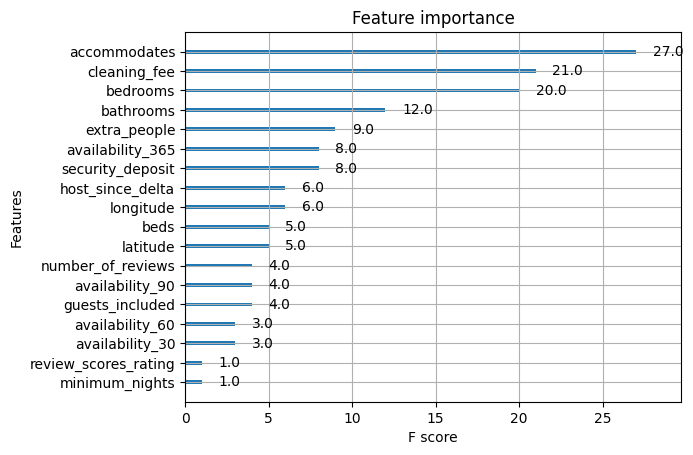

In [18]:
# Plot feature importances
xgb.plot_importance(xgboost_model)
plt.show()

#### The objective is to get the train and test samples performances as close as possible while maximizing the OOT performance.
#### The model above, with the specified paramaters accomplishes this

#### Now to ensure maximum performance on the true OOT data, we will retrain the model using the same parameters but combining the train, test and oot data all into the training set. This will allow us to get the most out of our data. 

##### Combine data into big training data

In [19]:
# Combine the train, test, and OOT datasets into one big training set
combined_df = pd.concat([xgb_train, xgb_test, xgb_oot], ignore_index=True)

# Separate features and target
X_combined = combined_df[numerical_features]
y_combined = combined_df[target].values.ravel()  


In [20]:
# Initialize the XGBoost model with the specified parameters
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,           
    max_depth=2,               
    learning_rate=0.05,         
    subsample=0.5,             
    colsample_bytree=0.5,      
    reg_alpha=5,               
    reg_lambda=5,              
    random_state=42            
)

# Train the model on the combined dataset
xgboost_model.fit(X_combined, y_combined)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Define the scoring metrics
scoring = {'rmse': make_scorer(mean_squared_error, squared=False),
           'r2': make_scorer(r2_score)}

# Perform cross-validation to evaluate the model
cv_results = cross_validate(xgboost_model, X_combined, y_combined, cv=5, scoring=scoring)

# Extract the RMSE and R^2 scores
cv_rmse_scores = cv_results['test_rmse']
cv_r2_scores = cv_results['test_r2']

# Create a dictionary with the evaluation metrics including Cross-Validation results
metrics_dict = {
    'Dataset': ['Train', 'Test', 'OOT', 'CV (Mean)'],
    'RMSE': [rmse_train, rmse_test, rmse_oot, np.mean(cv_rmse_scores)],
    'R^2': [r2_train, r2_test, r2_oot, np.mean(cv_r2_scores)]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Create DataFrame for CV fold results
cv_results_df = pd.DataFrame({
    'Dataset': [f'CV Fold {i+1}' for i in range(len(cv_rmse_scores))],
    'RMSE': cv_rmse_scores,
    'R^2': cv_r2_scores
})

# Concatenate the original metrics_df with the cv_results_df
metrics_df = pd.concat([metrics_df, cv_results_df], ignore_index=True)

# Display the DataFrame
metrics_df


,Dataset,RMSE,R^2
0,Train,103.786528,0.446058
1,Test,124.024431,0.422472
2,OOT,201.894417,0.143924
3,CV (Mean),124.310478,0.344022
4,CV Fold 1,113.933711,0.308497
5,CV Fold 2,107.061988,0.371114
6,CV Fold 3,116.574085,0.436248
7,CV Fold 4,120.438698,0.338384
8,CV Fold 5,163.543908,0.265867


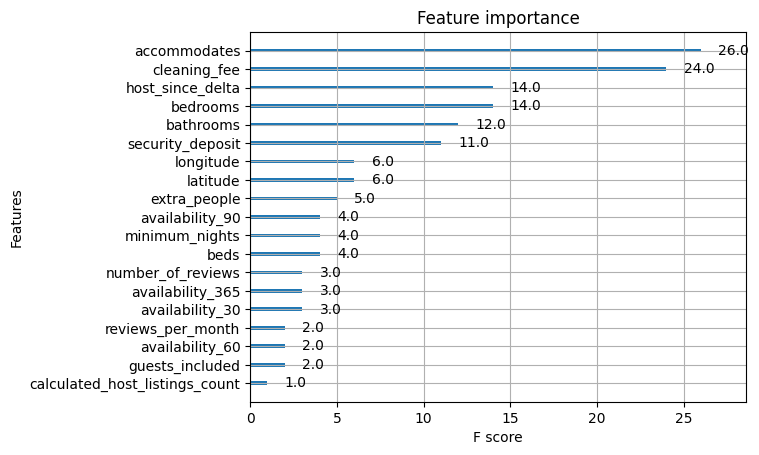

In [23]:
xgb.plot_importance(xgboost_model)
plt.show()

In [26]:
metrics_df.to_csv(data_path_out + 'xgb/model_performance.csv', index=False)

Save model for inference

In [25]:
model_folder = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/07_artifacts/"
model_filename = "xgboost_model.json"
model_path = os.path.join(model_folder, model_filename)
xgboost_model.save_model(model_path)

print(f"Model saved to {model_path}")

Model saved to C:/Users/Ahmed/OneDrive/Documents/projects/procore/07_artifacts/xgboost_model.json
